In [1]:
import math
import copy 
import tqdm
import time
import torch
import gpytorch
import pickle 
import itertools 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from math import comb
from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from IPython.display import clear_output

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "~/skisg/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98308/1388026961.py:16: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
import gpytorch as gp

from skisg.interp.sparse.construct import G 

from skisg.interp.rectgrid import get_basis, grid_points
from skisg.kernels.kernelsvizs import plot_kernel_function
from skisg.kernels.kernelsvizs import rbf_kernel, matern_kernel, sobolev1, sobolev2, sobolevinf


from skisg.config import SgBasisType, InterpType
from skisg.interp.sparse.sglocations import get_sg_points_nd
from skisg.interp.sparse.combination import spinterpolate

In [3]:
def plt_figure(sg_methods, rg_methods):

    plt.figure(figsize=(15, 6))

    for kind in [0, 1]:
        for basis in [0, 1, 3]:
            label = 'SG (' +  ('linear' if kind == 0 else 'cubic') + '+ '
            if basis == 0:
                label += ' naive)'
            elif basis == 1:
                label += ' modified)'
            elif basis == 2:
                label += ' const)'
            elif basis == 3:
                label += ' bound)'    

            sg_sizes = [i[1] for i in sg_methods[(kind, basis)]]
            sg_errors = [i[0] for i in sg_methods[(kind, basis)]]
            plt.plot(sg_sizes, sg_errors, label=label)

    plt.plot([i[1] for i in rg_methods['linear']], [i[0] for i in rg_methods['linear']], label='RG (linear)')
    plt.plot([i[1] for i in rg_methods['cubic']], [i[0] for i in rg_methods['cubic']], label='RG (cubic)')
    plt.legend(loc="lower left")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Error')
    plt.xlabel('Grid size')
    plt.show()

In [4]:
def err(f1, f2):
    return np.mean(np.abs(f1-f2))

def filer_duplicates(data):
    new_array = [tuple(row) for row in list(data)]
    return np.unique(new_array)

def all_train_points(X_test, minl=0, maxl=3, ndim=2, umin = 0.0, umax = 1.0):
    X_all = [X_test]
    for gl in range(minl, maxl+1):
        for basis in [0, 1, 2, 3]:
            X_all += get_sg_points_nd(gl, ndim, basis=SgBasisType(basis), ordered=True, umin=umin, umax=umax),
        grid_size_dim = int(np.floor(G(gl, ndim)**(1/ndim)))
        grid = [(umin, umax, grid_size_dim)]*ndim        
        X_all += grid_points(grid),

    X_all = np.vstack(X_all)
    return np.unique(X_all, axis=0)

def sample(x, cov):
    n = len(x)
    mu = np.zeros((n))
    Sigma = cov(x, x)
    f = np.random.multivariate_normal(mu, Sigma)
    return f

def funcdict(X, fdict):
    X = np.array(X).astype(np.float32)
    if len(X.shape) > 1:
        return np.array([funcdict(X[i, :], fdict) for i in range(X.shape[0])])
    return fdict[tuple(X)]

def setup_func(points, covs):
    ff = sample(points, covs) 
    fdict = {tuple(point):ff[i] for i,point in enumerate(points)}
    return lambda X: funcdict(X, fdict)

# For a spcific kernel, we sample function and look at the error 

def run_experiment(kernel_f, ndim=2, minl=1, maxl=3):
    
    ntest = 50
    
    umin = -0.1
    umax = 1.1

    rg_methods = defaultdict(list)
    sg_methods = defaultdict(list)  

    Xtest = np.random.rand(ntest, ndim)
    points = all_train_points(Xtest, minl=0, maxl=maxl, ndim=ndim, umin=umin, umax=umax).astype(np.float32)
    covs =  kernel_f

    print("Num unique points: ", points.shape[0])
    
    ff = sample(points, covs) 
    fdict = {tuple(point):ff[i] for i,point in enumerate(points)}
    func = lambda X: funcdict(X, fdict)

    # func = setup_func(points, covs)
    f_t = func(Xtest)

    for gl in tqdm.tqdm(range(1, maxl+1)):

        # sparse-grid 
        for kind in [0, 1]:
            for basis in [0, 1, 2, 3]:
                f_h, numpoints = spinterpolate(func, Xtest, gl, ndim, umin, umax, kind=InterpType(kind), basis=SgBasisType(basis))            
                sg_error = err(f_h, f_t),
                sg_methods[(kind, basis)] += (sg_error, numpoints),

        # regular-grid 
        grid_size_dim = int(np.floor(G(gl, ndim)**(1/ndim)))
        grid = [(umin, umax, grid_size_dim)]*ndim
        X = grid_points(grid)
        f_rg = func(X)

        # regular-grid-interpolation
        W = get_basis(Xtest, grid, kind='linear')
        f_h = (W@f_rg.reshape(-1, 1)).reshape(-1)
        rg_methods['linear'] += (err(f_h, f_t), X.shape[0]),

        W = get_basis(Xtest, grid, kind='cubic')
        f_h = (W@f_rg.reshape(-1, 1)).reshape(-1)
        rg_methods['cubic'] += (err(f_h, f_t), X.shape[0]),

    return sg_methods, rg_methods



Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.43it/s]


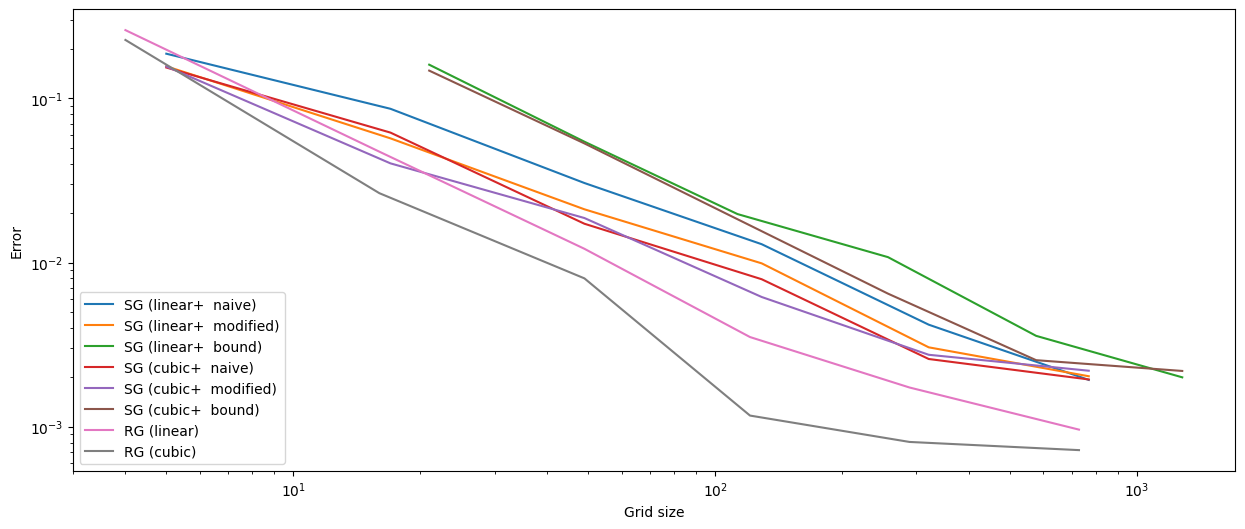

CPU times: user 17.2 s, sys: 2.42 s, total: 19.7 s
Wall time: 7.1 s


In [5]:
%%time 

plt_figure(*run_experiment(rbf_kernel, ndim=2, minl=1, maxl=6))

Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.07it/s]


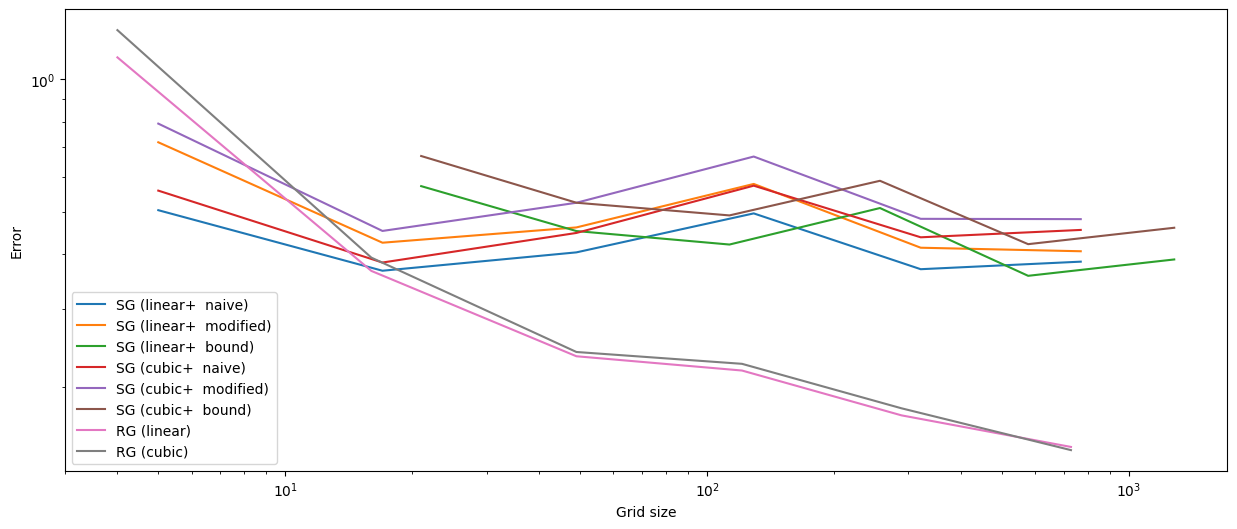

CPU times: user 17 s, sys: 2.36 s, total: 19.4 s
Wall time: 7.41 s


In [6]:
%%time 

matern0point5 = lambda X, X1 : matern_kernel(X, X1, nu=np.float32(0.5))

plt_figure(*run_experiment(matern0point5, ndim=2, minl=1, maxl=6))

Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.62it/s]


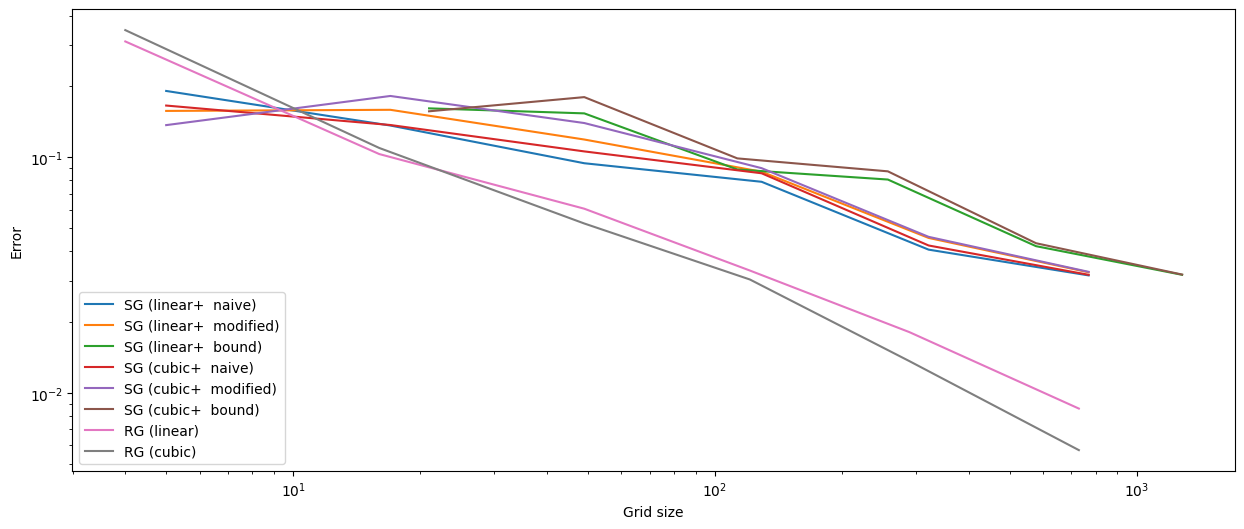

CPU times: user 16.5 s, sys: 2.19 s, total: 18.7 s
Wall time: 6.51 s


In [7]:
%%time 

matern1point5 = lambda X, X1 : matern_kernel(X, X1, nu=np.float32(1.5))

plt_figure(*run_experiment(matern1point5, ndim=2, minl=1, maxl=6))

Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.39it/s]


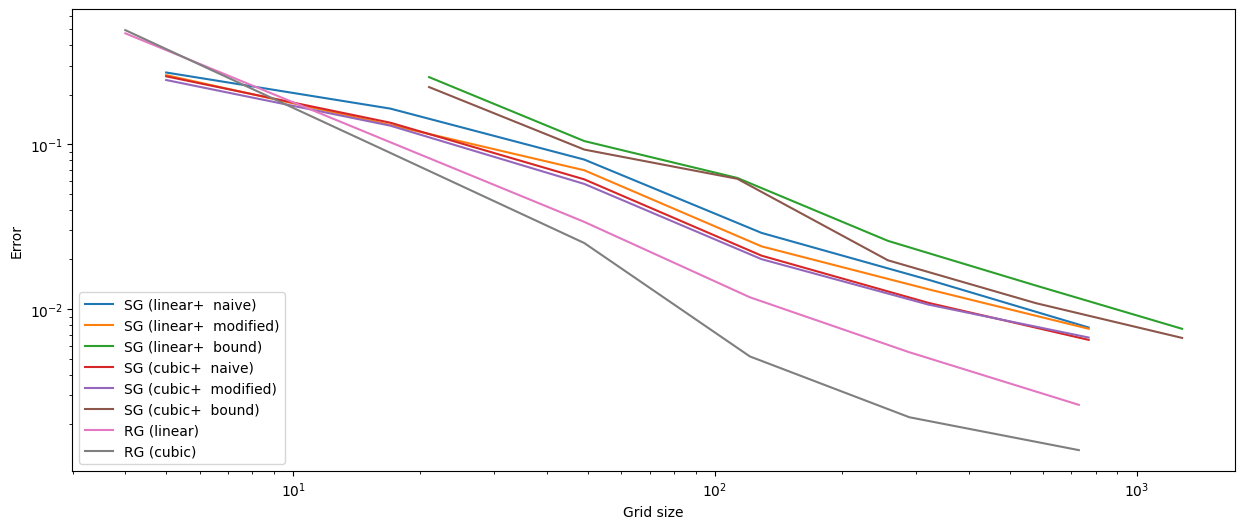

CPU times: user 17.1 s, sys: 2.26 s, total: 19.4 s
Wall time: 6.62 s


In [8]:
%%time 

matern2point5 = lambda X, X1 : matern_kernel(X, X1, nu=np.float32(2.5))

plt_figure(*run_experiment(matern2point5, ndim=2, minl=1, maxl=6))

Num unique points:  238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.19it/s]


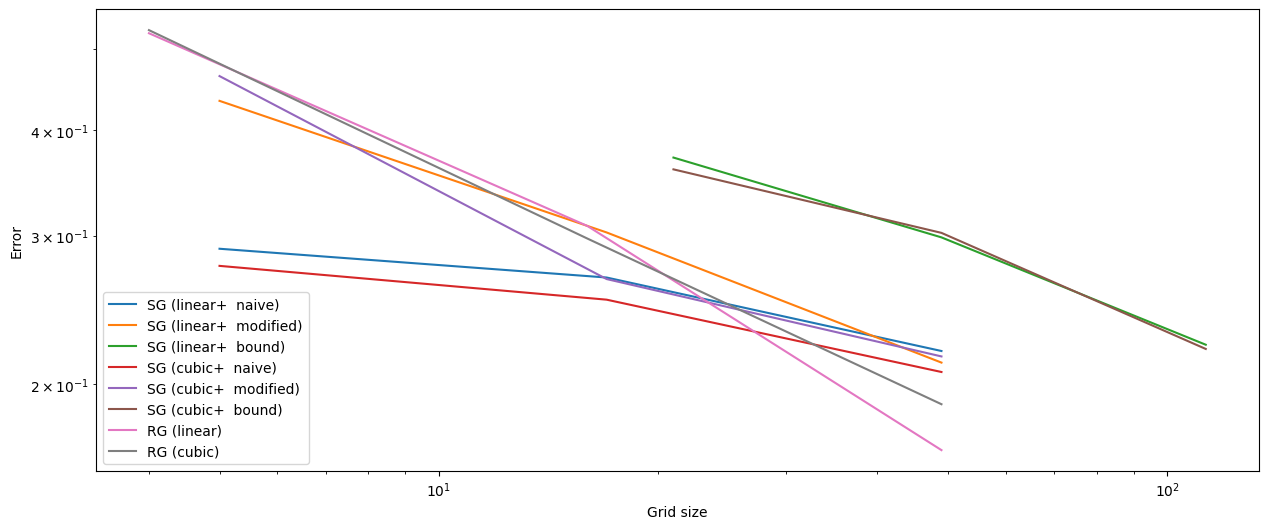

CPU times: user 885 ms, sys: 202 ms, total: 1.09 s
Wall time: 615 ms


In [9]:
%%time

plt_figure(*run_experiment(sobolev1, ndim=2, minl=1, maxl=3))

Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.25it/s]


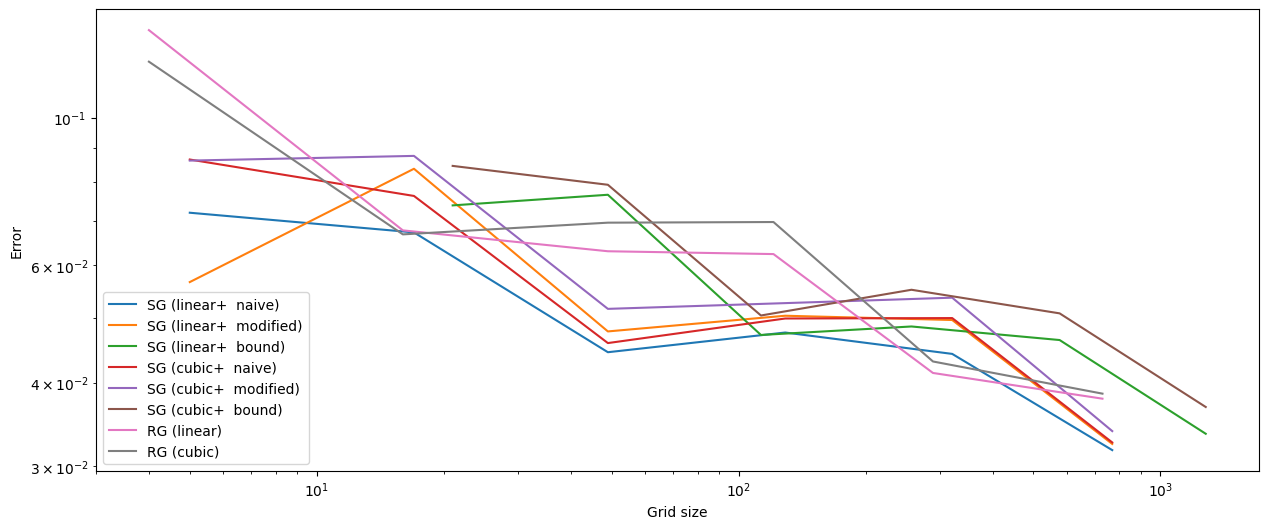

CPU times: user 17.1 s, sys: 2.26 s, total: 19.4 s
Wall time: 6.39 s


In [10]:
%%time

plt_figure(*run_experiment(sobolev2, ndim=2, minl=1, maxl=6))

Num unique points:  2462


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.95it/s]


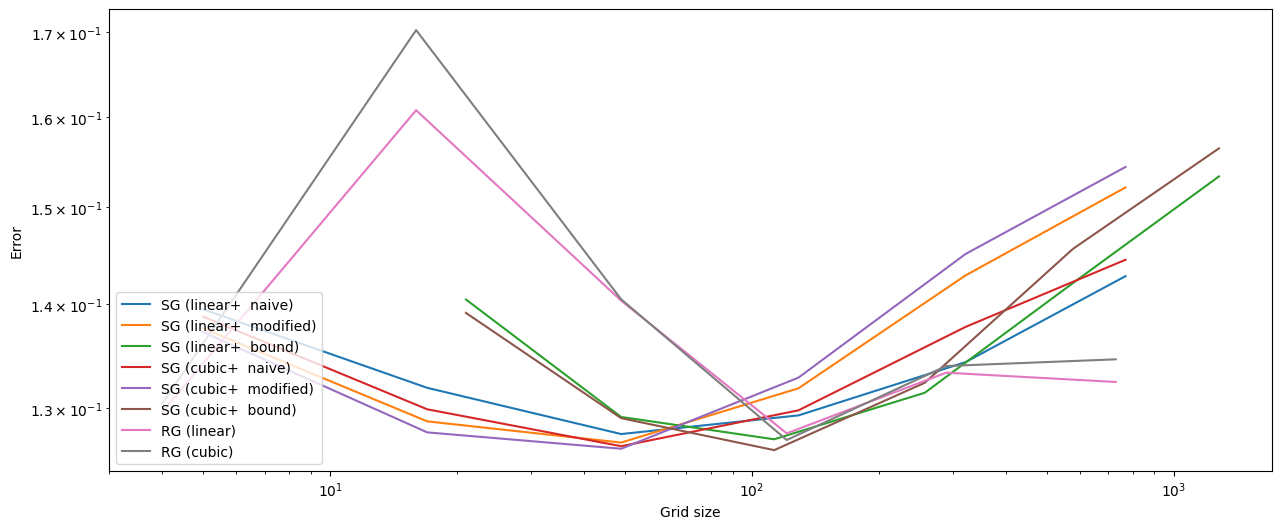

CPU times: user 17.5 s, sys: 2.26 s, total: 19.8 s
Wall time: 6.95 s


In [11]:
%%time

plt_figure(*run_experiment(sobolevinf, ndim=2, minl=1, maxl=6))